In [108]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
# URL to the raw CSV file on GitHub
csv_url = "https://raw.githubusercontent.com/cafrontadoe/laliga-match-prediction/main/laliga_2016_2024_matches.csv"

try:
    # Explicitly specify the delimiter as a comma
    df = pd.read_csv(csv_url, sep=',')

    # Display the first few rows and info to confirm it loaded correctly
    print("DataFrame loaded successfully:")
    print(df.head())
    print("\nDataFrame Info:")
    df.info()

except pd.errors.ParserError as e:
    print(f"A ParserError occurred even with sep=',' : {e}")
    print("This suggests a more complex issue, possibly with malformed lines or encoding.")
    print("Let's try with the 'python' engine for more robust parsing (though potentially slower).")
    try:
        df = pd.read_csv(csv_url, sep=',', engine='python')
        print("DataFrame loaded successfully with sep=',' and engine='python' :")
        print(df.head())
        print("\nDataFrame Info:")
        df.info()
    except Exception as e_py:
        print(f"Still encountering an error with engine='python': {e_py}")
        print("The file might be genuinely malformed or have an unusual encoding.")
        print("Please check the raw CSV file manually, especially around line 38, for any irregularities.")

DataFrame loaded successfully:
      season        date       home_team   away_team  home_team_goal  \
0  2016/2017  2016-08-19       Málaga CF  CA Osasuna               1   
1  2016/2017  2016-08-19  Dep. La Coruña    SD Eibar               2   
2  2016/2017  2016-08-20       Barcelona  Real Betis               6   
3  2016/2017  2016-08-20      Granada CF  Villarreal               1   
4  2016/2017  2016-08-20      Sevilla FC    Espanyol               6   

   away_team_goal  
0               1  
1               1  
2               2  
3               1  
4               4  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3420 entries, 0 to 3419
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   season          3420 non-null   object
 1   date            3420 non-null   object
 2   home_team       3420 non-null   object
 3   away_team       3420 non-null   object
 4   home_team_goal  3420 non

#Step 3: Clean column names in data frame
### - clean team names
### - convert data feature in datetime object

In [110]:
# Regular expression to find any text within parentheses
# r'\([^)]*\)' means:
# \(  -> an opening parenthesis (escaped because it's a special character in regex)
# [^)]* -> zero or more characters that are NOT a closing parenthesis
# \)  -> a closing parenthesis (escaped)
regex_pattern = r'\([^)]*\)'

# Clean the 'home_team' column
# Replace the matched pattern (parentheses and their content) with an empty string
# regex=True ensures the first argument is treated as a regular expression
df['home_team'] = df['home_team'].str.replace(regex_pattern, '', regex=True)

# Clean the 'away_team' column
# Apply the same cleaning process to the 'away_team' column
df['away_team'] = df['away_team'].str.replace(regex_pattern, '', regex=True)

# Optional: Remove extra leading or trailing whitespace that might remain
df['home_team'] = df['home_team'].str.strip()
df['away_team'] = df['away_team'].str.strip()


# Convert 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'])


df.head()


,season,date,home_team,away_team,home_team_goal,away_team_goal
0,2016/2017,2016-08-19,Málaga CF,CA Osasuna,1,1
1,2016/2017,2016-08-19,Dep. La Coruña,SD Eibar,2,1
2,2016/2017,2016-08-20,Barcelona,Real Betis,6,2
3,2016/2017,2016-08-20,Granada CF,Villarreal,1,1
4,2016/2017,2016-08-20,Sevilla FC,Espanyol,6,4


# Crear Column home_team_result para el Resultado del Partido (Target Variable)

In [111]:
# Create a 'home_team_result' column
def get_match_result(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 'Win'
    elif row['home_team_goal'] < row['away_team_goal']:
        return 'Loss'
    else:
        return 'Draw'

df['home_team_result'] = df.apply(get_match_result, axis=1)

df.head()

,season,date,home_team,away_team,home_team_goal,away_team_goal,home_team_result
0,2016/2017,2016-08-19,Málaga CF,CA Osasuna,1,1,Draw
1,2016/2017,2016-08-19,Dep. La Coruña,SD Eibar,2,1,Win
2,2016/2017,2016-08-20,Barcelona,Real Betis,6,2,Win
3,2016/2017,2016-08-20,Granada CF,Villarreal,1,1,Draw
4,2016/2017,2016-08-20,Sevilla FC,Espanyol,6,4,Win


#Feature engineering, adding goals_scored and goald_cenceded

In [112]:
# Step 1: Create team_stats_df
# Prepare home team data
home_df_stats = df[['date', 'home_team', 'home_team_goal', 'away_team_goal']].copy()
home_df_stats.rename(columns={
    'home_team': 'team',
    'home_team_goal': 'goals_scored',
    'away_team_goal': 'goals_conceded'
}, inplace=True)
# Calculate result from home team's perspective
home_df_stats['result'] = 'Draw'
home_df_stats.loc[home_df_stats['goals_scored'] > home_df_stats['goals_conceded'], 'result'] = 'Win'
home_df_stats.loc[home_df_stats['goals_scored'] < home_df_stats['goals_conceded'], 'result'] = 'Loss'

# Prepare away team data
away_df_stats = df[['date', 'away_team', 'away_team_goal', 'home_team_goal']].copy()
away_df_stats.rename(columns={
    'away_team': 'team',
    'away_team_goal': 'goals_scored',
    'home_team_goal': 'goals_conceded'
}, inplace=True)
# Calculate result from away team's perspective
away_df_stats['result'] = 'Draw'
away_df_stats.loc[away_df_stats['goals_scored'] > away_df_stats['goals_conceded'], 'result'] = 'Win'
away_df_stats.loc[away_df_stats['goals_scored'] < away_df_stats['goals_conceded'], 'result'] = 'Loss'

# Concatenate them into team_stats_df, ensuring a clean, new index
team_stats_df = pd.concat([home_df_stats, away_df_stats], ignore_index=True)

# Sort by team and date to calculate rolling averages correctly
team_stats_df = team_stats_df.sort_values(by=['team', 'date']).reset_index(drop=True)

print("\n--- Step 1: team_stats_df created and sorted ---")
print("First 10 rows of team_stats_df:")
team_stats_df.head(100)



--- Step 1: team_stats_df created and sorted ---
First 10 rows of team_stats_df:


,date,team,goals_scored,goals_conceded,result
0,2016-08-21,Alavés,1,1,Draw
1,2016-08-28,Alavés,0,0,Draw
2,2016-09-10,Alavés,2,1,Win
3,2016-09-19,Alavés,0,0,Draw
4,2016-09-22,Alavés,1,2,Loss
...,...,...,...,...,...
95,2019-01-18,Alavés,0,4,Loss
96,2019-01-28,Alavés,0,1,Loss
97,2019-02-03,Alavés,0,3,Loss
98,2019-02-11,Alavés,2,0,Win


#Feature Engineering, adding last_5 results (timing) and goals features

In [113]:
# Step 2: Calculate Rolling Averages and Rates
window_size = 5

team_stats_df['avg_goals_scored_last_5'] = team_stats_df.groupby('team')['goals_scored'].transform(
    lambda x: x.rolling(window=window_size, closed='left').mean().fillna(0)
)
team_stats_df['avg_goals_conceded_last_5'] = team_stats_df.groupby('team')['goals_conceded'].transform(
    lambda x: x.rolling(window=window_size, closed='left').mean().fillna(0)
)

# Calculate win/draw/loss rates
team_stats_df['is_win'] = (team_stats_df['result'] == 'Win').astype(int)
team_stats_df['is_draw'] = (team_stats_df['result'] == 'Draw').astype(int)
team_stats_df['is_loss'] = (team_stats_df['result'] == 'Loss').astype(int)

team_stats_df['win_rate_last_5'] = team_stats_df.groupby('team')['is_win'].transform(
    lambda x: x.rolling(window=window_size, closed='left').mean().fillna(0)
)
team_stats_df['draw_rate_last_5'] = team_stats_df.groupby('team')['is_draw'].transform(
    lambda x: x.rolling(window=window_size, closed='left').mean().fillna(0)
)
team_stats_df['loss_rate_last_5'] = team_stats_df.groupby('team')['is_loss'].transform(
    lambda x: x.rolling(window=window_size, closed='left').mean().fillna(0)
)

print("\n--- Step 2: Rolling Averages and Rates Calculated ---")
print("First 10 rows of team_stats_df with new features:")
# Displaying specific columns to make it readable
print(team_stats_df[['date', 'team', 'goals_scored', 'avg_goals_scored_last_5', 'win_rate_last_5']].head(10))
print("\nColumns in team_stats_df after rolling calculations:")
team_stats_df.head(500)


--- Step 2: Rolling Averages and Rates Calculated ---
First 10 rows of team_stats_df with new features:
        date    team  goals_scored  avg_goals_scored_last_5  win_rate_last_5
0 2016-08-21  Alavés             1                      0.0              0.0
1 2016-08-28  Alavés             0                      0.0              0.0
2 2016-09-10  Alavés             2                      0.0              0.0
3 2016-09-19  Alavés             0                      0.0              0.0
4 2016-09-22  Alavés             1                      0.0              0.0
5 2016-09-26  Alavés             3                      0.8              0.2
6 2016-10-01  Alavés             1                      1.2              0.4
7 2016-10-16  Alavés             1                      1.4              0.4
8 2016-10-22  Alavés             0                      1.2              0.2
9 2016-10-29  Alavés             1                      1.2              0.2

Columns in team_stats_df after rolling calculat

,date,team,goals_scored,goals_conceded,result,avg_goals_scored_last_5,avg_goals_conceded_last_5,is_win,is_draw,is_loss,win_rate_last_5,draw_rate_last_5,loss_rate_last_5
0,2016-08-21,Alavés,1,1,Draw,0.0,0.0,0,1,0,0.0,0.0,0.0
1,2016-08-28,Alavés,0,0,Draw,0.0,0.0,0,1,0,0.0,0.0,0.0
2,2016-09-10,Alavés,2,1,Win,0.0,0.0,1,0,0,0.0,0.0,0.0
3,2016-09-19,Alavés,0,0,Draw,0.0,0.0,0,1,0,0.0,0.0,0.0
4,2016-09-22,Alavés,1,2,Loss,0.0,0.0,0,0,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2021-08-21,Athletic,1,1,Draw,0.4,1.2,0,1,0,0.0,0.4,0.6
496,2021-08-28,Athletic,1,0,Win,0.2,1.0,1,0,0,0.0,0.4,0.6
497,2021-09-11,Athletic,2,0,Win,0.4,0.8,1,0,0,0.2,0.4,0.4
498,2021-09-18,Athletic,0,0,Draw,0.8,0.6,0,1,0,0.4,0.4,0.2


#Merging calculated features into original df

In [114]:
# Step 3: Merge calculated features back into the original df

# Columns to merge from team_stats_df (these are the calculated features)
stats_to_merge = [
    'date', 'team',
    'avg_goals_scored_last_5', 'avg_goals_conceded_last_5',
    'win_rate_last_5', 'draw_rate_last_5', 'loss_rate_last_5'
]

# --- Merge for Home Team Stats ---
# Create a copy of team_stats_df with only the relevant columns for home team merge
home_stats_for_merge = team_stats_df[stats_to_merge].copy()

# Explicitly rename columns with 'home_' prefix BEFORE merging
home_stats_for_merge.rename(columns={
    'team': 'home_team', # This will be the merge key
    'avg_goals_scored_last_5': 'home_avg_goals_scored_last_5',
    'avg_goals_conceded_last_5': 'home_avg_goals_conceded_last_5',
    'win_rate_last_5': 'home_win_rate_last_5',
    'draw_rate_last_5': 'home_draw_rate_last_5',
    'loss_rate_last_5': 'home_loss_rate_last_5'
}, inplace=True)

# Perform the merge for home team stats
# The 'home_team' column in home_stats_for_merge now acts as the merge key
df = df.merge(
    home_stats_for_merge,
    left_on=['date', 'home_team'],
    right_on=['date', 'home_team'], # Merge on 'date' and the renamed 'home_team'
    how='left'
)

# --- Merge for Away Team Stats ---
# Create a copy of team_stats_df with only the relevant columns for away team merge
away_stats_for_merge = team_stats_df[stats_to_merge].copy()

# Explicitly rename columns with 'away_' prefix BEFORE merging
away_stats_for_merge.rename(columns={
    'team': 'away_team', # This will be the merge key
    'avg_goals_scored_last_5': 'away_avg_goals_scored_last_5',
    'avg_goals_conceded_last_5': 'away_avg_goals_conceded_last_5',
    'win_rate_last_5': 'away_win_rate_last_5',
    'draw_rate_last_5': 'away_draw_rate_last_5',
    'loss_rate_last_5': 'away_loss_rate_last_5'
}, inplace=True)

# Perform the merge for away team stats
# The 'away_team' column in away_stats_for_merge now acts as the merge key
df = df.merge(
    away_stats_for_merge,
    left_on=['date', 'away_team'],
    right_on=['date', 'away_team'], # Merge on 'date' and the renamed 'away_team'
    how='left'
)

print("\n--- Step 3: Final DataFrame with Merged Features ---")
print("First 15 rows of df with new features (selected columns):")
# Now, these columns should exist without issue
'''
df[['date', 'home_team', 'away_team',
          'home_avg_goals_scored_last_5', 'away_avg_goals_scored_last_5',
          'home_win_rate_last_5', 'away_win_rate_last_5']].head(500)

print(f"\nFinal DataFrame shape: {df.shape}")
print("\nFinal DataFrame columns:")
print(df.columns.tolist()) # Convert to list for easier viewing
print("-" * 50)
'''
df.head(500)


--- Step 3: Final DataFrame with Merged Features ---
First 15 rows of df with new features (selected columns):


,season,date,home_team,away_team,home_team_goal,away_team_goal,home_team_result,home_avg_goals_scored_last_5,home_avg_goals_conceded_last_5,home_win_rate_last_5,home_draw_rate_last_5,home_loss_rate_last_5,away_avg_goals_scored_last_5,away_avg_goals_conceded_last_5,away_win_rate_last_5,away_draw_rate_last_5,away_loss_rate_last_5
0,2016/2017,2016-08-19,Málaga CF,CA Osasuna,1,1,Draw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016/2017,2016-08-19,Dep. La Coruña,SD Eibar,2,1,Win,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016/2017,2016-08-20,Barcelona,Real Betis,6,2,Win,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016/2017,2016-08-20,Granada CF,Villarreal,1,1,Draw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016/2017,2016-08-20,Sevilla FC,Espanyol,6,4,Win,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2017/2018,2017-11-19,Málaga CF,Dep. La Coruña,3,2,Win,0.4,1.8,0.2,0.0,0.8,1.2,1.0,0.4,0.2,0.4
496,2017/2018,2017-11-19,Espanyol,Valencia,0,2,Loss,0.4,0.8,0.2,0.4,0.4,3.6,1.2,1.0,0.0,0.0
497,2017/2018,2017-11-19,UD Las Palmas,Levante,0,2,Loss,0.6,3.6,0.0,0.0,1.0,0.8,1.4,0.0,0.6,0.4
498,2017/2018,2017-11-19,Athletic,Villarreal,1,1,Draw,0.8,1.8,0.2,0.0,0.8,2.4,0.4,0.8,0.2,0.0


# Encode team names

In [115]:
# Get all unique team names from both columns
all_teams = pd.concat([df['home_team'], df['away_team']]).unique()
print(f"\nTotal unique teams: {len(all_teams)}")


Total unique teams: 30


#  One-Hot Encode 'home_team' and 'away_team'

### - create two columns by each team, one home_ and one away_

In [116]:
# One-Hot Encode 'home_team' and 'away_team'
# This will create many new columns (one for each team)
df = pd.get_dummies(df, columns=['home_team', 'away_team'], prefix=['home', 'away'])




DataFrame with One-Hot Encoded Teams (showing a few columns):


,season,date,home_team_goal,away_team_goal,home_team_result,home_avg_goals_scored_last_5,home_avg_goals_conceded_last_5,home_win_rate_last_5,home_draw_rate_last_5,home_loss_rate_last_5,...,away_Real Sociedad,away_Real Valladolid,away_SD Eibar,away_SD Huesca,away_Sevilla FC,away_Sporting Gijón,away_UD Almería,away_UD Las Palmas,away_Valencia,away_Villarreal
0,2016/2017,2016-08-19,1,1,Draw,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,2016/2017,2016-08-19,2,1,Win,0.0,0.0,0.0,0.0,0.0,...,False,False,True,False,False,False,False,False,False,False
2,2016/2017,2016-08-20,6,2,Win,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,2016/2017,2016-08-20,1,1,Draw,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
4,2016/2017,2016-08-20,6,4,Win,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False


In [119]:
# Set display options to show all columns and prevent wrapping
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000) # You can adjust this number based on your screen width

print("--- First 100 rows of the DataFrame with all columns ---")
print(df.head(100))

# Reset display options to default (optional, but good practice if you don't want them to persist)
pd.reset_option('display.max_columns')
pd.reset_option('display.width')

--- First 100 rows of the DataFrame with all columns ---
       season       date  home_team_goal  away_team_goal home_team_result  home_avg_goals_scored_last_5  home_avg_goals_conceded_last_5  home_win_rate_last_5  home_draw_rate_last_5  home_loss_rate_last_5  away_avg_goals_scored_last_5  away_avg_goals_conceded_last_5  away_win_rate_last_5  away_draw_rate_last_5  away_loss_rate_last_5  home_Alavés  home_Athletic  home_Atlético Madrid  home_Barcelona  home_CA Osasuna  home_CD Leganés  home_Celta de Vigo  home_Cádiz CF  home_Dep. La Coruña  home_Elche CF  home_Espanyol  home_Getafe  home_Girona  home_Granada CF  home_Levante  home_Málaga CF  home_RCD Mallorca  home_Rayo Vallecano  home_Real Betis  home_Real Madrid  home_Real Sociedad  home_Real Valladolid  home_SD Eibar  home_SD Huesca  home_Sevilla FC  home_Sporting Gijón  home_UD Almería  home_UD Las Palmas  home_Valencia  home_Villarreal  away_Alavés  away_Athletic  away_Atlético Madrid  away_Barcelona  away_CA Osasuna  away_CD Leg

#EDA over Engineered features

### Correlational table


--- Generating Correlation Matrix ---


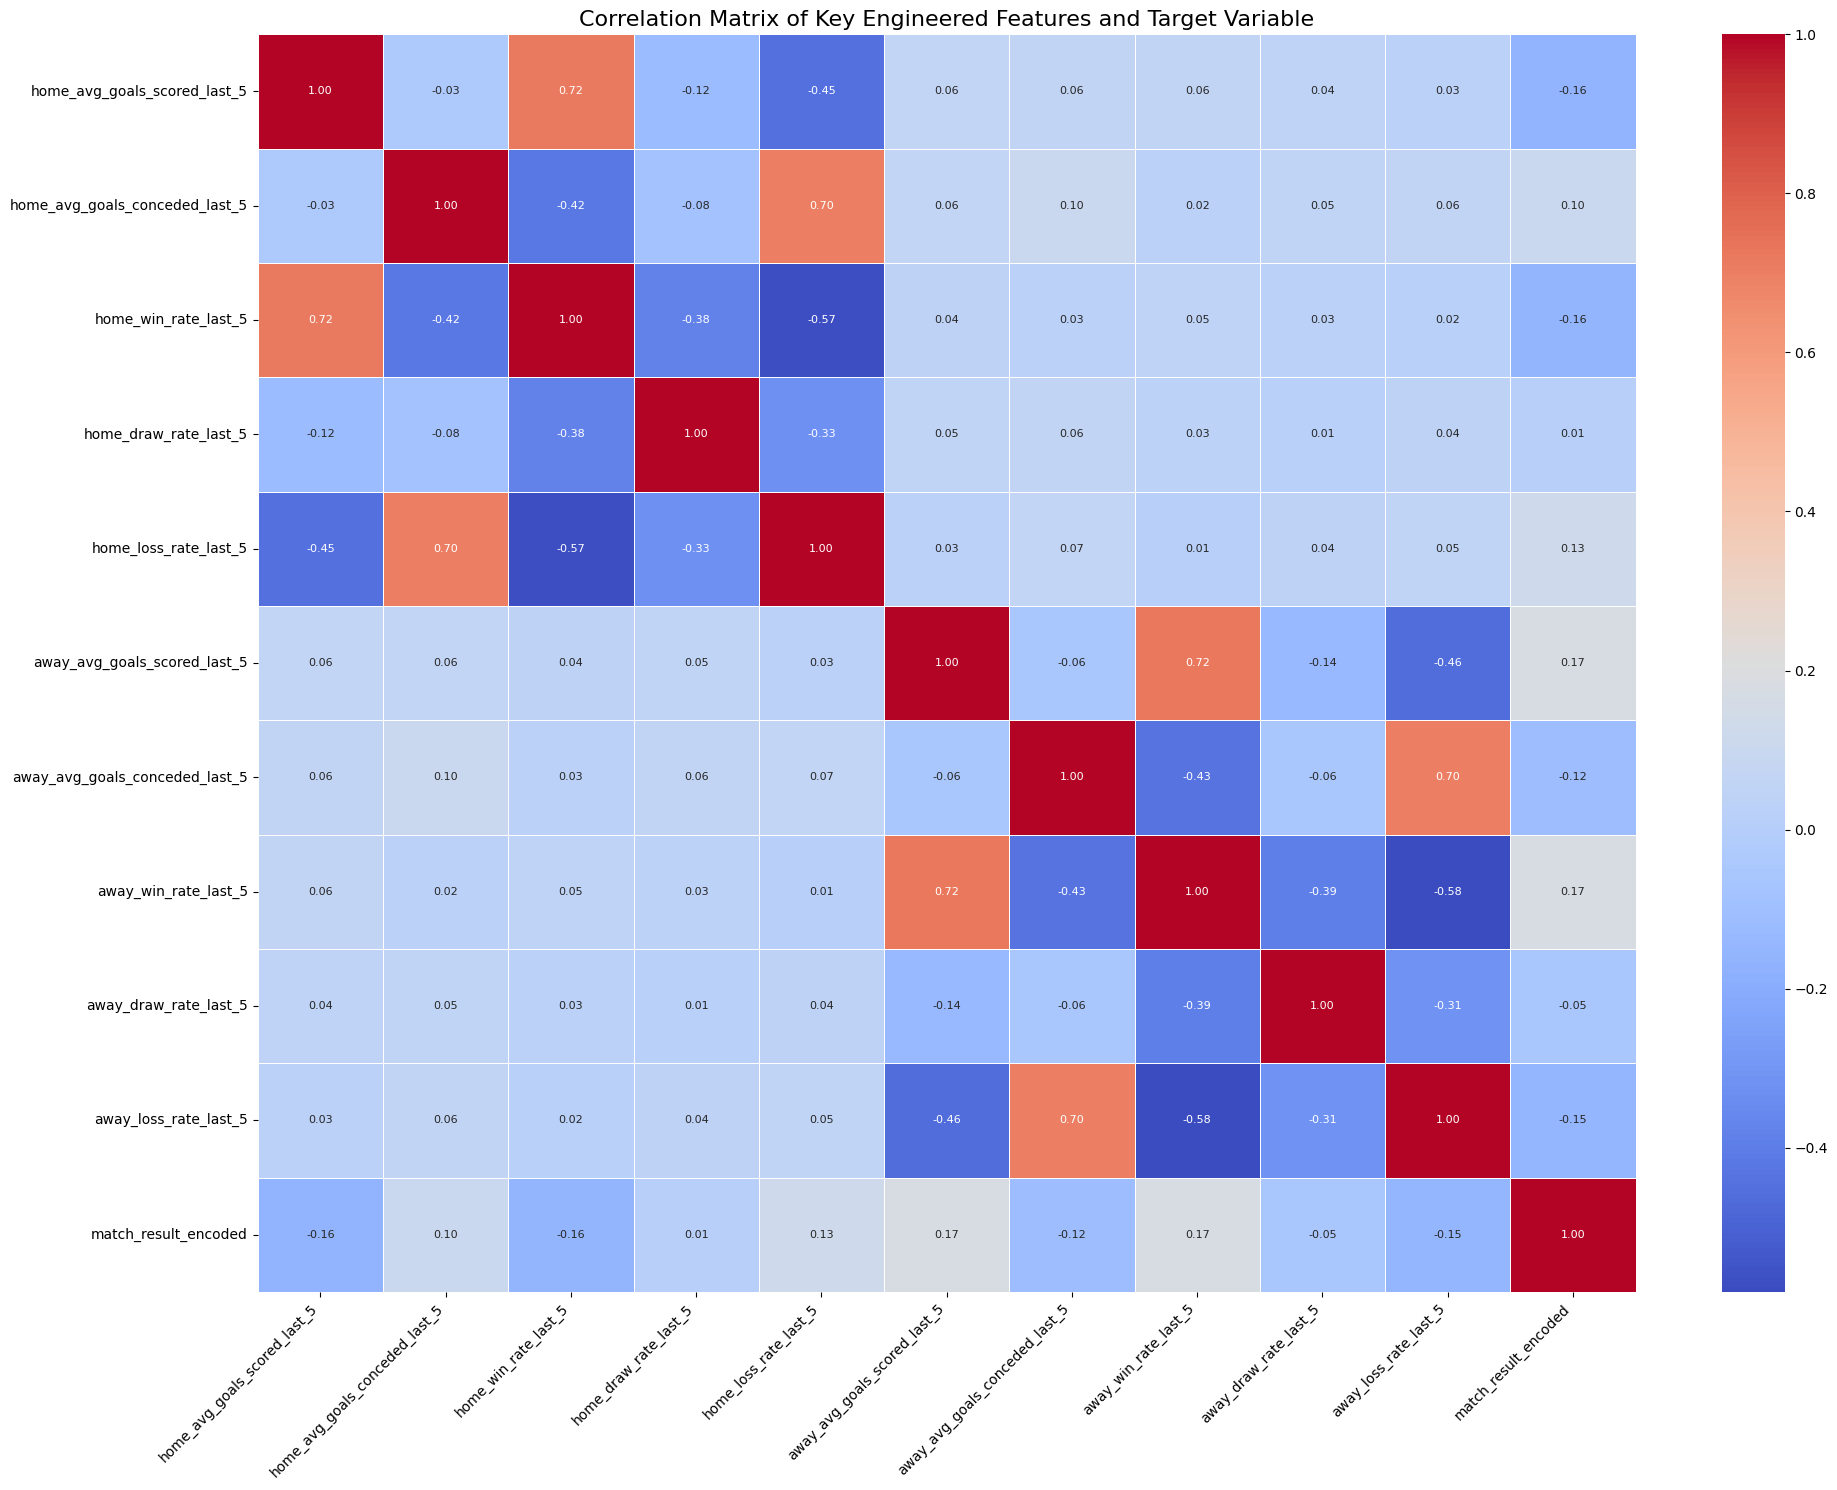


--- Top/Bottom Correlations with Target Variable (match_result_encoded) ---
Top 10 Positive Correlations:
away_team_goal                    0.610863
away_win_rate_last_5              0.174020
away_avg_goals_scored_last_5      0.172736
away_Barcelona                    0.171289
away_Real Madrid                  0.160130
home_loss_rate_last_5             0.128434
away_Atlético Madrid              0.104336
home_avg_goals_conceded_last_5    0.101360
home_Real Valladolid              0.069356
home_UD Las Palmas                0.055730
Name: match_result_encoded, dtype: float64

Top 10 Negative Correlations:
away_Granada CF                  -0.065950
away_UD Las Palmas               -0.066834
away_avg_goals_conceded_last_5   -0.116803
home_Atlético Madrid             -0.126813
home_Real Madrid                 -0.128407
home_Barcelona                   -0.130001
away_loss_rate_last_5            -0.154076
home_win_rate_last_5             -0.158629
home_avg_goals_scored_last_5     -0.163752
ho

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- IMPORTANT: Re-run the previous steps to ensure 'df' is correctly prepared ---
# If your environment reset, you might need to re-run:
# 1. Your initial df loading and date conversion.
# 2. Step 1: Creation of team_stats_df.
# 3. Step 2: Calculation of rolling averages and rates on team_stats_df.
# 4. Step 3: Merging of home and away stats into df (the explicit renaming method).
# 5. Your one-hot encoding step for team names (which you mentioned you had previously).

# --- Ensure the target variable is encoded ---
# This is crucial for correlation with the target.
# If 'match_result_encoded' already exists, this will just re-map it.
result_mapping = {'Win': 0, 'Draw': 1, 'Loss': 2}
df['match_result_encoded'] = df['home_team_result'].map(result_mapping)

# --- Select only the numerical columns for the correlation matrix ---
# 'number' includes int, float. 'bool' includes True/False for one-hot encoded columns.
numerical_df = df.select_dtypes(include=['number', 'bool']).copy()

# --- Handle potential constant columns from one-hot encoding ---
# If a team doesn't appear in the first few rows, its one-hot column might be all False/0.
# This causes issues for correlation. We drop columns that have no variance.
# We also want to exclude the original home_team_goal and away_team_goal from this specific analysis
# if we are focusing on the *engineered* features' correlation with the outcome.
# For this specific correlation matrix, let's focus on the engineered features and the target.
# We'll keep the one-hot encoded team columns as they are engineered features.

# Identify columns that are constant (all same value)
constant_cols = [col for col in numerical_df.columns if numerical_df[col].nunique() <= 1]
if constant_cols:
    print(f"Dropping constant columns for correlation matrix: {constant_cols}")
    numerical_df.drop(columns=constant_cols, inplace=True)


print("\n--- Generating Correlation Matrix ---")
plt.figure(figsize=(20, 15)) # Adjust figure size for better readability

# Calculate the correlation matrix
corr_matrix = numerical_df.corr()

# --- Filter for relevant columns to make the heatmap readable ---
# We'll include all 'last_5' features and the 'match_result_encoded' target.
# You can also manually add specific one-hot encoded team columns if you want to see their direct correlation.
relevant_cols = [col for col in corr_matrix.columns if 'last_5' in col or 'match_result_encoded' in col]

# Optional: Add a few specific one-hot encoded team columns to the heatmap if you want to see their direct correlation
# For example, if 'Barcelona' is a prominent team in your data:
# if 'home_Barcelona' in corr_matrix.columns:
#     relevant_cols.append('home_Barcelona')
# if 'away_Real Madrid' in corr_matrix.columns:
#     relevant_cols.append('away_Real Madrid')

# Ensure all selected relevant_cols actually exist in the corr_matrix
relevant_cols = [col for col in relevant_cols if col in corr_matrix.columns]

# Filter the correlation matrix to show only relevant columns
corr_matrix_filtered = corr_matrix.loc[relevant_cols, relevant_cols]


sns.heatmap(corr_matrix_filtered, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
plt.title('Correlation Matrix of Key Engineered Features and Target Variable', fontsize=16)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.yticks(rotation=0) # Keep y-axis labels horizontal
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print("\n--- Top/Bottom Correlations with Target Variable (match_result_encoded) ---")
# Sort correlations with the target variable
# Exclude the target variable's self-correlation (which is always 1)
target_correlations = corr_matrix['match_result_encoded'].drop('match_result_encoded').sort_values(ascending=False)

print("Top 10 Positive Correlations:")
print(target_correlations.head(10))
print("\nTop 10 Negative Correlations:")
print(target_correlations.tail(10))
print("-" * 50)

# Handle Any Remaining Missing Values (NaNs)

In [121]:
# Check for any remaining missing values in the entire DataFrame
print("\n--- Checking for Missing Values in the Final DataFrame ---")
missing_values_summary = df.isnull().sum()
missing_values_summary = missing_values_summary[missing_values_summary > 0]

if not missing_values_summary.empty:
    print("Columns with missing values and their counts:")
    print(missing_values_summary)
    # Decide on a strategy to handle these NaNs.
    # For numerical features, filling with 0 or the mean/median is common.
    # For categorical/boolean features, filling with a specific value or the mode might be appropriate.
    # If a column has too many NaNs, dropping the column might be considered.
    # For now, let's fill numerical NaNs with 0 as a common default for features,
    # but be aware this might need adjustment based on the specific column.
    # This will primarily affect any NaNs that might have appeared in the original df
    # or were not specifically handled by the rolling calculations.

    # Identify numerical columns that still have NaNs
    numerical_cols_with_nan = missing_values_summary[df[missing_values_summary.index].dtypes != 'object'].index
    if not numerical_cols_with_nan.empty:
        print(f"\nFilling numerical NaNs in {list(numerical_cols_with_nan)} with 0.")
        df[numerical_cols_with_nan] = df[numerical_cols_with_nan].fillna(0)
    else:
        print("\nNo numerical columns with NaNs found that need filling with 0.")

    # Re-check after filling
    missing_values_summary_after_fill = df.isnull().sum()
    missing_values_summary_after_fill = missing_values_summary_after_fill[missing_values_summary_after_fill > 0]
    if not missing_values_summary_after_fill.empty:
        print("\nMissing values remaining after numerical fill:")
        print(missing_values_summary_after_fill)
        print("Please inspect these remaining NaNs (likely in object/text columns) and decide on a strategy.")
    else:
        print("\nAll missing values handled.")

else:
    print("No missing values found in the DataFrame. Great!")

print("-" * 50)


--- Checking for Missing Values in the Final DataFrame ---
No missing values found in the DataFrame. Great!
--------------------------------------------------


# Split Your Data (Chronologically)

In [122]:
# Ensure the DataFrame is sorted by date before splitting
df = df.sort_values(by='date').reset_index(drop=True)

# Define features (X) and target (y)
# X will contain all the columns that are inputs to our model.
# y will be our target variable: 'match_result_encoded'.

# Columns to EXCLUDE from features (X):
# - 'season', 'date': Not direct features for the model, used for sorting/context.
# - 'home_team', 'away_team': Replaced by one-hot encoded versions.
# - 'home_team_result': Original text target, replaced by 'match_result_encoded'.
# - 'match_result_encoded': This is our target variable (y), so it shouldn't be in X.

# Create a list of columns to drop from X
columns_to_drop_from_X = [
    'season', 'date', 'home_team', 'away_team', 'home_team_result', 'match_result_encoded'
]

# Filter out columns that might not exist if they were already dropped (e.g., 'home_team' if one-hot encoded)
columns_to_drop_from_X = [col for col in columns_to_drop_from_X if col in df.columns]

X = df.drop(columns=columns_to_drop_from_X)
y = df['match_result_encoded']

# Determine the split point for chronological split
# A common split is 80% for training and 20% for testing.
split_point = int(len(df) * 0.8)

X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

print("\n--- Data Split (Chronological) ---")
print(f"Total number of matches: {len(df)}")
print(f"Training set size: {len(X_train)} matches")
print(f"Test set size: {len(X_test)} matches")
print(f"Training data date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].iloc[split_point-1].strftime('%Y-%m-%d')}")
print(f"Test data date range: {df['date'].iloc[split_point].strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
print(f"Number of features (columns in X_train): {X_train.shape[1]}")
print(f"First 5 rows of X_train (features):")
print(X_train.head())
print(f"\nFirst 5 rows of y_train (target):")
print(y_train.head())
print("-" * 50)


--- Data Split (Chronological) ---
Total number of matches: 3420
Training set size: 2736 matches
Test set size: 684 matches
Training data date range: 2016-08-19 to 2023-10-01
Test data date range: 2023-10-01 to 2025-05-25
Number of features (columns in X_train): 72
First 5 rows of X_train (features):
   home_team_goal  away_team_goal  home_avg_goals_scored_last_5  \
0               1               1                           0.0   
1               2               1                           0.0   
2               6               2                           0.0   
3               1               1                           0.0   
4               6               4                           0.0   

   home_avg_goals_conceded_last_5  home_win_rate_last_5  \
0                             0.0                   0.0   
1                             0.0                   0.0   
2                             0.0                   0.0   
3                             0.0                   0.0   